# 5. 数据批次抽取分析

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 读取的adata结果

In [2]:
import os

batch_extract_dir = "batch_extract"
name_list = os.listdir(batch_extract_dir)[:-2]
dir_list = ["%s/%s"%(batch_extract_dir, name) for name in name_list]

velovgi_adata_list = []
scvelo_adata_list = []

for dir in dir_list:
    print(dir)
    velovgi_adata_list.append(velovgi.tl.read_adata("%s/adata"%dir))
    scvelo_adata_list.append(scv.read("%s/adata_scvelo.h5ad"%dir))

velovgi_adata_list, scvelo_adata_list

batch_extract/E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
load batch_extract/E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5/adata/adata.h5ad
load batch_extract/E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5/adata/sample_recover.pkl
batch_extract/E7.0-E7.5-E8.0-E8.5
load batch_extract/E7.0-E7.5-E8.0-E8.5/adata/adata.h5ad
load batch_extract/E7.0-E7.5-E8.0-E8.5/adata/sample_recover.pkl
batch_extract/E7.0-E7.75-E8.5
load batch_extract/E7.0-E7.75-E8.5/adata/adata.h5ad
load batch_extract/E7.0-E7.75-E8.5/adata/sample_recover.pkl
batch_extract/E7.0-E8.0
load batch_extract/E7.0-E8.0/adata/adata.h5ad
load batch_extract/E7.0-E8.0/adata/sample_recover.pkl


([AnnData object with n_obs × n_vars = 500 × 2000
      obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
      var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
      uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
      obsm: 'X_pca', 'X_umap', 'velocity_umap'
      layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
      obsp: 'connectivities', 'distances',
  AnnData object with n_obs × n_vars = 311 × 1623
      obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
      var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', '

## 2. 指标整理

1. 指标计算

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_key = "celltype"
cluster_edges = [
    ("Blood progenitors 1", "Blood progenitors 2"), 
    ("Blood progenitors 2", "Erythroid1"), 
    ("Erythroid1", "Erythroid2"), 
    ("Erythroid2", "Erythroid3")
    ] # 已知的细胞类型间的分化信息

df_velovgi = velovgi.tl.get_metric_total_df(name_list, velovgi_adata_list, cluster_edges, cluster_key) # 指标计算
df_velovgi.to_csv("./batch_extract/metric_df_velovgi.csv")

df_scvelo = velovgi.tl.get_metric_total_df(name_list, scvelo_adata_list, cluster_edges, cluster_key) # 指标计算
df_scvelo.to_csv("./batch_extract/metric_df_scvelo.csv")

2. 拼接

In [4]:
import pandas as pd
if "Dataset" not in df_velovgi.columns:
    df_velovgi["Dataset"] = df_velovgi["Model"]
    df_velovgi["Model"] = "velovgi"
if "Dataset" not in df_scvelo.columns:
    df_scvelo["Dataset"] = df_scvelo["Model"]
    df_scvelo["Model"] = "scvelo"

df = pd.concat([df_velovgi, df_scvelo])
df

,CBDir,Metric,Score,ICVCoh,Model,Dataset
0,0.702666,CBDir,0.702666,NaN,velovgi,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
1,-0.642120,CBDir,-0.642120,NaN,velovgi,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
2,0.724673,CBDir,0.724673,NaN,velovgi,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
3,-0.974112,CBDir,-0.974112,NaN,velovgi,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
4,0.543152,CBDir,0.543152,NaN,velovgi,E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5
...,...,...,...,...,...,...
156,NaN,ICVCoh,0.892379,0.892379,scvelo,E7.0-E8.0
157,NaN,ICVCoh,0.890162,0.890162,scvelo,E7.0-E8.0
158,NaN,ICVCoh,0.848779,0.848779,scvelo,E7.0-E8.0
159,NaN,ICVCoh,0.962167,0.962167,scvelo,E7.0-E8.0


In [5]:
import math

def str_auto_wrap(s, wrap_len=15):
    # 按照指定长度换行
    s_auto_wrap_list = []
    for i in range(math.ceil(len(s)/wrap_len)):
        s_auto_wrap_list.append(s[i*wrap_len:(i+1)*wrap_len])
    return "\n".join(s_auto_wrap_list)

# sorted_categories = sorted(df["Dataset"].unique(), key=lambda x:len(x), reverse=True) # 按照批次数量排序
sorted_categories = sorted(df["Dataset"].unique(), key=lambda x:len(x)) # 按照批次数量排序,少的在前
sorted_categories_auto_wrap = [str_auto_wrap(i) for i in sorted_categories]
transfer_dict = dict(zip(sorted_categories, sorted_categories_auto_wrap)) 

# 
df["Dataset"] = df["Dataset"].apply(lambda x: transfer_dict[x])
df["Dataset"] = df["Dataset"].astype("category")
df["Dataset"] = df["Dataset"].cat.set_categories(sorted_categories_auto_wrap)

transfer_dict

{'E7.0-E8.0': 'E7.0-E8.0',
 'E7.0-E7.75-E8.5': 'E7.0-E7.75-E8.5',
 'E7.0-E7.5-E8.0-E8.5': 'E7.0-E7.5-E8.0-\nE8.5',
 'E7.0-E7.25-E7.5-E7.75-E8.0-E8.25-E8.5': 'E7.0-E7.25-E7.5\n-E7.75-E8.0-E8.\n25-E8.5'}

3. 绘图

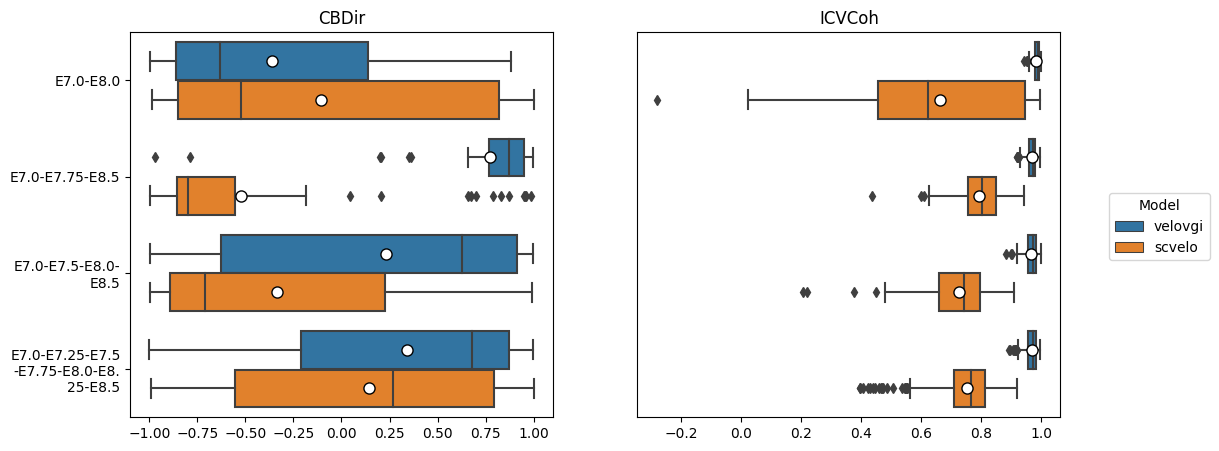

In [6]:
# 横向
fig, ax = plt.subplots(1,2, figsize=(12,5))

x = "Score"
y = "Dataset"
orient = "h"

sns.boxplot(
    df.loc[df["Metric"].isin(["CBDir"])],
    orient=orient, x=x, y=y, hue="Model", 
    ax=ax[0], showmeans=True,
    meanprops={"marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"8"})
ax[0].set_title("CBDir")
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].legend_.remove()

sns.boxplot(
    df.loc[df["Metric"].isin(["ICVCoh"])],
    orient=orient, x=x, y=y, hue="Model", 
    ax=ax[1], showmeans=True,
    meanprops={"marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"8"})
ax[1].set_title("ICVCoh")
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1.1, 0.6)) # 移动图例(1,1)表示图形右上端

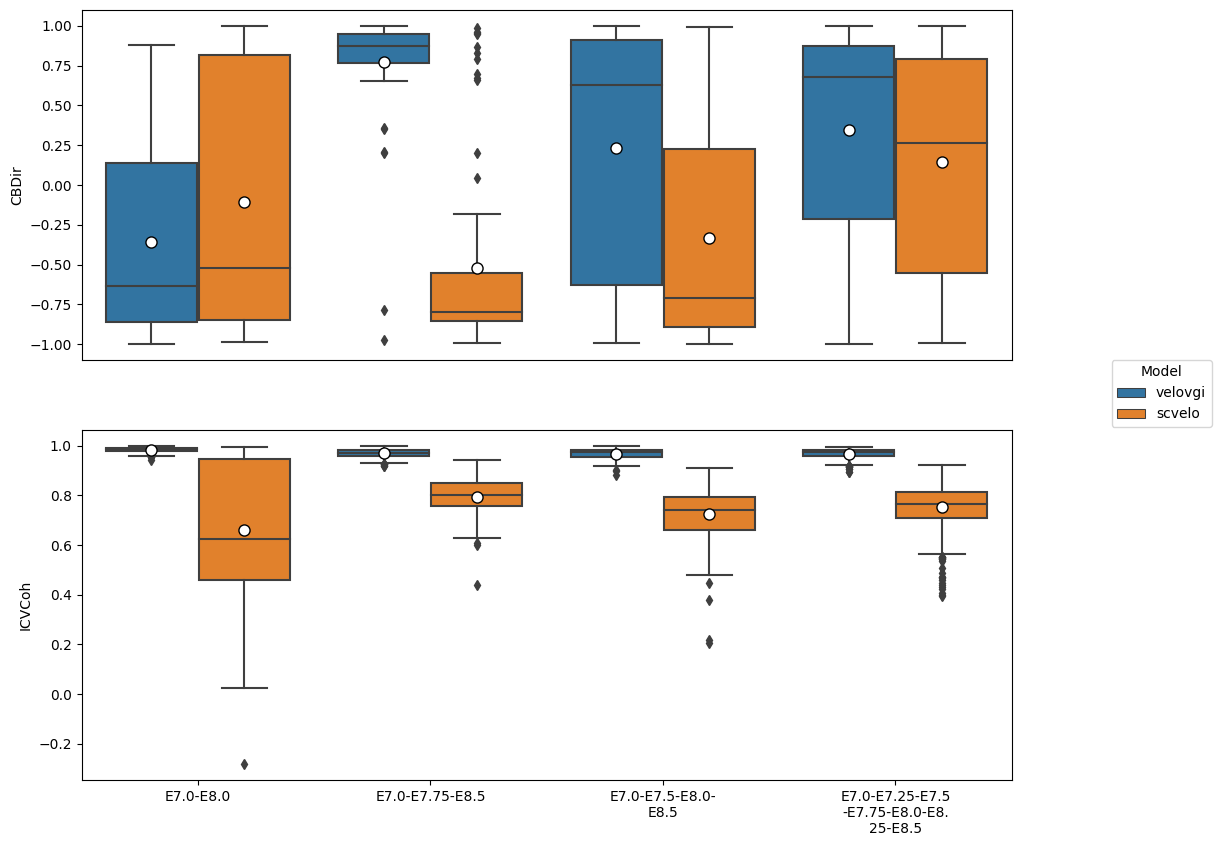

In [7]:
# 横向
fig, ax = plt.subplots(2,1, figsize=(12,10))

x = "Dataset"
y = "Score"
orient = "v"

sns.boxplot(
    df.loc[df["Metric"].isin(["CBDir"])],
    orient=orient, x=x, y=y, hue="Model", 
    ax=ax[0], showmeans=True,
    meanprops={"marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"8"})
ax[0].set_xlabel("")
ax[0].set_xticks([])
ax[0].set_ylabel("CBDir")
ax[0].legend_.remove()

sns.boxplot(
    df.loc[df["Metric"].isin(["ICVCoh"])],
    orient=orient, x=x, y=y, hue="Model", 
    ax=ax[1], showmeans=True,
    meanprops={"marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"8"})
ax[1].set_xlabel("")
ax[1].set_ylabel("ICVCoh")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1.1, 1.22)) # 移动图例(1,1)表示图形右上端